#### Setup


In [1]:
import torch
import torchvision
from lib.data_handlers import Load_ImageNet100, Load_PACS, Load_ImageNet100Sketch
from overcomplete.models import DinoV2, ViT, ResNet, ViT_Large, SigLIP
from torch.utils.data import DataLoader, TensorDataset
from overcomplete.sae import TopKSAE, train_sae
from overcomplete.visualization import (overlay_top_heatmaps, evidence_top_images, zoom_top_images, contour_top_image)
import os
import matplotlib.pyplot as plt
from einops import rearrange
from lib.universal_trainer import train_usae
from lib.activation_generator import Load_activation_dataloader
import torch.nn as nn
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from lib.eval import evaluate_models
from lib.visualizer import visualize_concepts
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

### Train a USAE

Define Models and Generate Their Activations

In [2]:
models = {
    "Dino": DinoV2(device="cuda"),
    "ViT": ViT(device="cuda")
}

activation_dir = "activations/ImageNet100_Sketch_Dino_ViT"
image_loader = Load_ImageNet100Sketch(transform=None, batch_size=256, shuffle=True)


activations_dataloader = Load_activation_dataloader(
    models=models,
    image_dataloader=image_loader,
    max_seq_len=196,   
    save_dir=activation_dir, 
    generate=False,  
    rearrange_string='n t d -> (n t) d'
    )

Using cache found in C:\Users\sproj_ha/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\sproj_ha/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\sproj_ha/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\sproj_ha/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
c:\Users\sproj_ha\miniconda3\envs\interpretability\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SAE Training

In [3]:
concepts = 768 * 8
epochs = 50
lr=3e-4
sample = next(iter(activations_dataloader))

In [4]:
SAEs = {}
optimizers = {}
schedulers = {}

for key, model in models.items():

    SAEs[key] = TopKSAE(
        sample[f"activations_{key}"].shape[-1],
        nb_concepts=concepts,
        top_k=16,
        device="cuda",
    )
    optimizers[key] = torch.optim.Adam(SAEs[key].parameters(), lr=lr)

    # Set up a Linear + Cosine Scheduler
    warmup_scheduler = LinearLR(
        optimizers[key], start_factor=1e-6 / 3e-4, end_factor=1.0, total_iters=10
    )
    cosine_scheduler = CosineAnnealingLR(optimizers[key], T_max=epochs, eta_min=1e-6)
    schedulers[key] = SequentialLR(
        optimizers[key],
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[25],
    )

criterion = nn.L1Loss(reduction="mean")  # change to mean reduction

In [5]:
train_usae(
    names=list(models.keys()),
    models=SAEs,
    dataloader=activations_dataloader,
    criterion=criterion,
    nb_epochs=epochs,
    optimizers=optimizers,
    schedulers=schedulers,
    device="cuda",
    seed=42,
)

Epoch 1/50:   9%|▉         | 48/508 [00:23<02:49,  2.72it/s, loss=1.65]c:\Users\sproj_ha\miniconda3\envs\interpretability\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1/50: 100%|██████████| 508/508 [03:20<00:00,  2.54it/s, loss=1.33]



[Epoch 1] Loss: 763.1322 | Time: 200.33s | Dead Features: 0.0%


Epoch 2/50: 100%|██████████| 508/508 [03:02<00:00,  2.79it/s, loss=1.23]



[Epoch 2] Loss: 650.4296 | Time: 182.31s | Dead Features: 0.0%


Epoch 3/50: 100%|██████████| 508/508 [02:58<00:00,  2.85it/s, loss=1.2] 



[Epoch 3] Loss: 612.3526 | Time: 178.50s | Dead Features: 0.0%


Epoch 4/50: 100%|██████████| 508/508 [02:59<00:00,  2.83it/s, loss=1.17]



[Epoch 4] Loss: 594.0518 | Time: 179.41s | Dead Features: 0.0%


Epoch 5/50: 100%|██████████| 508/508 [02:59<00:00,  2.83it/s, loss=1.15]



[Epoch 5] Loss: 582.4541 | Time: 179.68s | Dead Features: 0.0%


Epoch 6/50: 100%|██████████| 508/508 [03:01<00:00,  2.81it/s, loss=1.17]



[Epoch 6] Loss: 575.2312 | Time: 181.07s | Dead Features: 0.0%


Epoch 7/50: 100%|██████████| 508/508 [03:02<00:00,  2.78it/s, loss=1.14]



[Epoch 7] Loss: 569.8462 | Time: 182.71s | Dead Features: 0.0%


Epoch 8/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.11]



[Epoch 8] Loss: 565.7948 | Time: 184.40s | Dead Features: 0.0%


Epoch 9/50: 100%|██████████| 508/508 [03:03<00:00,  2.76it/s, loss=1.13]



[Epoch 9] Loss: 562.5210 | Time: 183.76s | Dead Features: 0.0%


Epoch 10/50: 100%|██████████| 508/508 [03:03<00:00,  2.77it/s, loss=1.13]



[Epoch 10] Loss: 559.9510 | Time: 183.55s | Dead Features: 0.1%


Epoch 11/50: 100%|██████████| 508/508 [03:04<00:00,  2.76it/s, loss=1.13]



[Epoch 11] Loss: 557.7051 | Time: 184.37s | Dead Features: 0.1%


Epoch 12/50: 100%|██████████| 508/508 [03:04<00:00,  2.76it/s, loss=1.12]



[Epoch 12] Loss: 555.9130 | Time: 184.08s | Dead Features: 0.1%


Epoch 13/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.11]



[Epoch 13] Loss: 554.2698 | Time: 184.65s | Dead Features: 0.3%


Epoch 14/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.13] 



[Epoch 14] Loss: 552.8268 | Time: 184.80s | Dead Features: 0.6%


Epoch 15/50: 100%|██████████| 508/508 [03:03<00:00,  2.76it/s, loss=1.12] 



[Epoch 15] Loss: 551.4764 | Time: 183.98s | Dead Features: 1.0%


Epoch 16/50: 100%|██████████| 508/508 [03:03<00:00,  2.77it/s, loss=1.09]



[Epoch 16] Loss: 550.2070 | Time: 183.47s | Dead Features: 1.4%


Epoch 17/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.11]



[Epoch 17] Loss: 548.9606 | Time: 184.63s | Dead Features: 2.4%


Epoch 18/50: 100%|██████████| 508/508 [03:04<00:00,  2.76it/s, loss=1.1] 



[Epoch 18] Loss: 547.8856 | Time: 184.23s | Dead Features: 2.8%


Epoch 19/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.12]



[Epoch 19] Loss: 546.9116 | Time: 184.41s | Dead Features: 3.7%


Epoch 20/50: 100%|██████████| 508/508 [03:03<00:00,  2.76it/s, loss=1.11]



[Epoch 20] Loss: 545.9363 | Time: 183.91s | Dead Features: 5.2%


Epoch 21/50: 100%|██████████| 508/508 [03:04<00:00,  2.76it/s, loss=1.1]  



[Epoch 21] Loss: 544.9445 | Time: 184.12s | Dead Features: 6.0%


Epoch 22/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.08]



[Epoch 22] Loss: 543.8842 | Time: 184.51s | Dead Features: 7.3%


Epoch 23/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.09]



[Epoch 23] Loss: 542.9999 | Time: 184.91s | Dead Features: 8.3%


Epoch 24/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.1] 



[Epoch 24] Loss: 542.0936 | Time: 184.98s | Dead Features: 9.5%


Epoch 25/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.1] 



[Epoch 25] Loss: 541.3260 | Time: 184.94s | Dead Features: 10.7%


Epoch 26/50: 100%|██████████| 508/508 [03:05<00:00,  2.74it/s, loss=1.07] 



[Epoch 26] Loss: 540.5342 | Time: 185.10s | Dead Features: 12.2%


Epoch 27/50: 100%|██████████| 508/508 [03:04<00:00,  2.76it/s, loss=1.09]



[Epoch 27] Loss: 539.8501 | Time: 184.23s | Dead Features: 13.2%


Epoch 28/50: 100%|██████████| 508/508 [03:02<00:00,  2.78it/s, loss=1.08]



[Epoch 28] Loss: 539.0030 | Time: 182.97s | Dead Features: 14.6%


Epoch 29/50: 100%|██████████| 508/508 [03:02<00:00,  2.78it/s, loss=1.09]



[Epoch 29] Loss: 538.2246 | Time: 182.45s | Dead Features: 15.4%


Epoch 30/50: 100%|██████████| 508/508 [03:03<00:00,  2.76it/s, loss=1.09]



[Epoch 30] Loss: 537.5801 | Time: 183.93s | Dead Features: 16.1%


Epoch 31/50: 100%|██████████| 508/508 [03:01<00:00,  2.79it/s, loss=1.08] 



[Epoch 31] Loss: 536.9230 | Time: 181.84s | Dead Features: 18.0%


Epoch 32/50: 100%|██████████| 508/508 [03:03<00:00,  2.76it/s, loss=1.08]



[Epoch 32] Loss: 536.2931 | Time: 183.93s | Dead Features: 18.5%


Epoch 33/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.09]



[Epoch 33] Loss: 535.7454 | Time: 184.49s | Dead Features: 18.4%


Epoch 34/50: 100%|██████████| 508/508 [03:02<00:00,  2.78it/s, loss=1.08] 



[Epoch 34] Loss: 535.2340 | Time: 182.83s | Dead Features: 19.8%


Epoch 35/50: 100%|██████████| 508/508 [03:02<00:00,  2.78it/s, loss=1.08]



[Epoch 35] Loss: 534.6667 | Time: 182.83s | Dead Features: 20.7%


Epoch 36/50: 100%|██████████| 508/508 [03:03<00:00,  2.76it/s, loss=1.07]



[Epoch 36] Loss: 534.1301 | Time: 183.91s | Dead Features: 22.0%


Epoch 37/50: 100%|██████████| 508/508 [03:04<00:00,  2.76it/s, loss=1.08] 



[Epoch 37] Loss: 533.6165 | Time: 184.09s | Dead Features: 22.3%


Epoch 38/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.07] 



[Epoch 38] Loss: 533.1311 | Time: 184.86s | Dead Features: 22.8%


Epoch 39/50: 100%|██████████| 508/508 [03:03<00:00,  2.77it/s, loss=1.06] 



[Epoch 39] Loss: 532.6249 | Time: 183.24s | Dead Features: 23.1%


Epoch 40/50: 100%|██████████| 508/508 [03:03<00:00,  2.76it/s, loss=1.07] 



[Epoch 40] Loss: 532.2082 | Time: 183.78s | Dead Features: 23.0%


Epoch 41/50: 100%|██████████| 508/508 [03:04<00:00,  2.76it/s, loss=1.07] 



[Epoch 41] Loss: 531.7632 | Time: 184.22s | Dead Features: 23.8%


Epoch 42/50: 100%|██████████| 508/508 [03:04<00:00,  2.76it/s, loss=1.06] 



[Epoch 42] Loss: 531.3709 | Time: 184.17s | Dead Features: 24.5%


Epoch 43/50: 100%|██████████| 508/508 [03:03<00:00,  2.77it/s, loss=1.06] 



[Epoch 43] Loss: 530.9144 | Time: 183.60s | Dead Features: 24.7%


Epoch 44/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.07] 



[Epoch 44] Loss: 530.5102 | Time: 184.98s | Dead Features: 25.0%


Epoch 45/50: 100%|██████████| 508/508 [03:04<00:00,  2.76it/s, loss=1.07] 



[Epoch 45] Loss: 530.1267 | Time: 184.25s | Dead Features: 25.2%


Epoch 46/50: 100%|██████████| 508/508 [03:03<00:00,  2.77it/s, loss=1.06] 



[Epoch 46] Loss: 529.7184 | Time: 183.70s | Dead Features: 25.5%


Epoch 47/50: 100%|██████████| 508/508 [03:05<00:00,  2.74it/s, loss=1.08] 



[Epoch 47] Loss: 529.3599 | Time: 185.15s | Dead Features: 26.1%


Epoch 48/50: 100%|██████████| 508/508 [03:03<00:00,  2.77it/s, loss=1.07] 



[Epoch 48] Loss: 528.9405 | Time: 183.22s | Dead Features: 26.2%


Epoch 49/50: 100%|██████████| 508/508 [03:04<00:00,  2.75it/s, loss=1.07] 



[Epoch 49] Loss: 528.6036 | Time: 184.78s | Dead Features: 26.0%


Epoch 50/50: 100%|██████████| 508/508 [03:04<00:00,  2.76it/s, loss=1.05] 


[Epoch 50] Loss: 528.1778 | Time: 184.30s | Dead Features: 26.3%


In [6]:
model_state_dicts = {name: model.state_dict() for name, model in SAEs.items()}
model_path = "./models/USAE_Dino_ViT"
torch.save(model_state_dicts, model_path)

In [6]:
model_path = "./models/USAE_Dino_ViT"

state = torch.load(model_path)

for name, sae in SAEs.items():
    print(sae.load_state_dict(state[name]))

<All keys matched successfully>
<All keys matched successfully>


In [ ]:
val_activation_dir = "activations/ImageNet100_Dino_ViT_VAL"
val_image_loader = Load_ImageNet100(root_dir=r"C:\Users\sproj_ha\Desktop\vision_interp\datasets\imagenet100\val.X", transform=None, batch_size=256, shuffle=True)

val_activations_dataloader = Load_activation_dataloader(
    models=models,
    image_dataloader=val_image_loader,
    max_seq_len=196,   
    save_dir=val_activation_dir, 
    generate=True,  
    rearrange_string='n t d -> (n t) d'
)

In [8]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange
import heapq
from overcomplete.visualization.plot_utils import (
    get_image_dimensions,
    interpolate_cv2,
    show,
)
from overcomplete.visualization.cmaps import VIRIDIS_ALPHA
import os
import itertools
from pathlib import Path
from multiprocessing import Pool


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def save_concept_plot(concept_id, save_dir):
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists

    filename = f"concept_{concept_id:04d}.png"
    filepath = save_dir / filename
    plt.savefig(filepath, bbox_inches="tight", dpi=300)


def plot_concept_grid(concept_id, heaps, SAEs, n_images, save_dir, counter):
    """
    Plots and saves the visualization grid for a single concept.
    """
    rows_per_model = 2
    total_rows = len(SAEs) * rows_per_model
    fig = plt.figure(figsize=(n_images * 2.5, total_rows * 2.5))

    for j, (name, _) in enumerate(SAEs.items()):
        heap = heaps[name][concept_id]
        # fill_heap_with_black(heap, n_images, counter)
        # top_items = get_top_items_from_heap(heap, n_images)

        title_row = j * rows_per_model + 1
        image_row_start = title_row + 1

        # Title row
        title_ax = plt.subplot(total_rows, n_images, (title_row - 1) * n_images + 1)
        plt.axis("off")
        plt.text(
            0.5,
            0.5,
            name,
            ha="center",
            va="center",
            fontsize=14,
            weight="bold",
            transform=title_ax.transAxes,
        )

        # Image rows
        for i in range(n_images):

            if i > len(heap):
                image = torch.zeros((3, 224, 224))
                ax = plt.subplot(total_rows, n_images, idx)
                ax.axis("off")
                show(image)
            
            else:
                idx = (image_row_start - 1) * n_images + i + 1
                image = heap[i][2]["image"]
                heat = heap[i][2]["heatmap"]
                width, height = get_image_dimensions(image)
                heatmap = interpolate_cv2(heat, (width, height))
                ax = plt.subplot(total_rows, n_images, idx)
                ax.axis("off")
                show(image)
                show(heatmap, cmap=VIRIDIS_ALPHA, alpha=1.0)

    plt.tight_layout()
    save_concept_plot(concept_id, save_dir)
    plt.close()



def visualize_concepts(
    activation_loader,
    SAEs,
    save_dir,
    patch_width,
    num_concepts,
    n_images=10,
    abort_threshold=0,
):
    # Initialize a heap for each model that will store the (score, image) for ONE model
    heaps = {}
    heaps = {
        name: {concept_id: [] for concept_id in range(num_concepts)}
        for name in SAEs.keys()
    }

    # Initialize Tie Breaker on Heaps
    counter = itertools.count()

    #### OPTIMIZED VISUALIZER
    for batch in tqdm(activation_loader):

        for name, sae in SAEs.items():

            # Encode only once
            with torch.no_grad():
                _, heatmaps = sae.encode(
                    batch[f"activations_{name}"].squeeze().to(device)
                )
                heatmaps = rearrange(
                    heatmaps, "(n w h) d -> n w h d", w=patch_width, h=patch_width
                )  # shape: [B, w, h, D]

            B, w, h, D = heatmaps.shape

            # Compute mean heatmap per image per concept: [B, D]
            mean_heatmaps = heatmaps.mean(dim=(1, 2))  # shape: [B, D]

            # Get top-k per concept efficiently using torch.topk
            # indices: [k, D], values: [k, D]
            topk_values, topk_indices = torch.topk(mean_heatmaps.T, k=n_images, dim=1)

            for concept_id in range(D):

                for rank in range(n_images):
                    idx = topk_indices[concept_id, rank].item()
                    score = topk_values[concept_id, rank].item()

                    # Only proceed if this score is better than the worst in the heap, or heap not full AND score is not 0
                    heap = heaps[name][concept_id]
                    if (
                        len(heap) < n_images or -score > heap[0][0]
                    ) and score > abort_threshold:
                        z = {
                            "image": batch["images"].squeeze()[idx].cpu(),
                            "heatmap": heatmaps[idx, :, :, concept_id].cpu(),
                        }
                        score_item = (-score, next(counter), z)

                        if len(heap) < n_images:
                            heapq.heappush(heap, score_item)
                        else:
                            heapq.heappushpop(heap, score_item)

    for concept in tqdm(range(num_concepts)):
        if all(len(heaps[name][concept]) == 0 for name in SAEs.keys()):
            continue  # DO NOT VISUALIZE CONCEPT IF ITS EMPTY FOR ALL MODELS
        else:
            plot_concept_grid(concept, heaps, SAEs, n_images, save_dir, counter)



  0%|          | 0/6144 [00:00<?, ?it/s]


IndexError: list index out of range

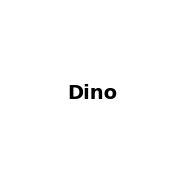

In [9]:
visualize_concepts(
    activation_loader=val_activations_dataloader,
    SAEs=SAEs,
    num_concepts=concepts,
    n_images=8,
    patch_width=14, 
    save_dir="results/visualizer_Dino_ViT/",
    abort_threshold=0.0,
)

In [ ]:
### SAVE THE Z_sAES and then on them
